# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## 0 - Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install pyunlocbox` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers

In [3]:
import networkx as nx
import pandas as pd

For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

In [5]:
adjacency =  np.load('symm_adj.npy')
weighted_adj = np.load('weighted_adj.npy')
W = weighted_adj + weighted_adj.T

In [6]:
idx_GC = np.load("idx_largest_component.npy")
GC = W[idx_GC, :]
GC = GC[:, idx_GC]
GC_sparse = sparse.csr_matrix(GC)

In [7]:
n_degree = np.sum(GC,axis=0)
D = sparse.diags(n_degree)
laplacian_combinatorial = D - GC_sparse

# Your code here.
D_root_inv = sparse.diags(np.sqrt(1/n_degree))
laplacian_normalized =  D_root_inv.dot(laplacian_combinatorial.dot(D_root_inv))

In [8]:
PortGeo = pd.read_csv('PortGeo.csv')

In [9]:
idx_hub = np.where(n_degree>1000)

In [10]:
n_nodes = GC.shape[0]
latitude = np.zeros(n_nodes)
longtitude = np.zeros(n_nodes)

In [11]:
idx_hub

(array([179, 225, 243, 383, 492]),)

In [113]:
label = np.zeros(n_nodes)
for i in idx_hub[0]:
    label += GC[:,i]
label[label>0]=1
label[label<1]=0

In [13]:
for i in range(len(GC)):
    if len(PortGeo.loc[PortGeo['index']==idx_GC[i]].Latitude.get_values()):
        latitude[i] = PortGeo.loc[PortGeo['index']==idx_GC[i]].Latitude.get_values()[0]
        longtitude[i] = PortGeo.loc[PortGeo['index']==idx_GC[i]].Longitude.get_values()[0]

In [114]:
#laplacian = laplacian_normalized# Your code here.
laplacian = laplacian_combinatorial
# gradient = # Your code here. ?S.T @ x
labels = label# Your code here.s
n_nodes = GC.shape[0]# Your code here.

In [15]:
# labels = U[:,1]
# labels[labels>=-0.03] = 1
# labels[labels<-0.03] = -1

**ANSWER**

As shown above, we decide to choose the airports linked to top-5 busiest airports as label 1, and the rest airports not-linked to these 5 airport as label 0.

## 1 - Graph Fourier Transform

In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

In [16]:
def G_pos(x,y,n_nodes):
    pos_dic = {}
    for i in range(n_nodes):
        pos_dic[i] = x[i],y[i]
    return pos_dic

In [17]:
pos = G_pos(x=longtitude,y=latitude,n_nodes=n_nodes)

In [18]:
G=nx.from_numpy_array(GC)

We can use edge list to show edges you want to show.

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.Graph.edges.html

An example of edges.

In [78]:
e,U = np.linalg.eigh(laplacian.A)

In [104]:
def GFT(x):
    return U.T @ x# Your code here.

def iGFT(x): 
    return U @ x# Your code here.

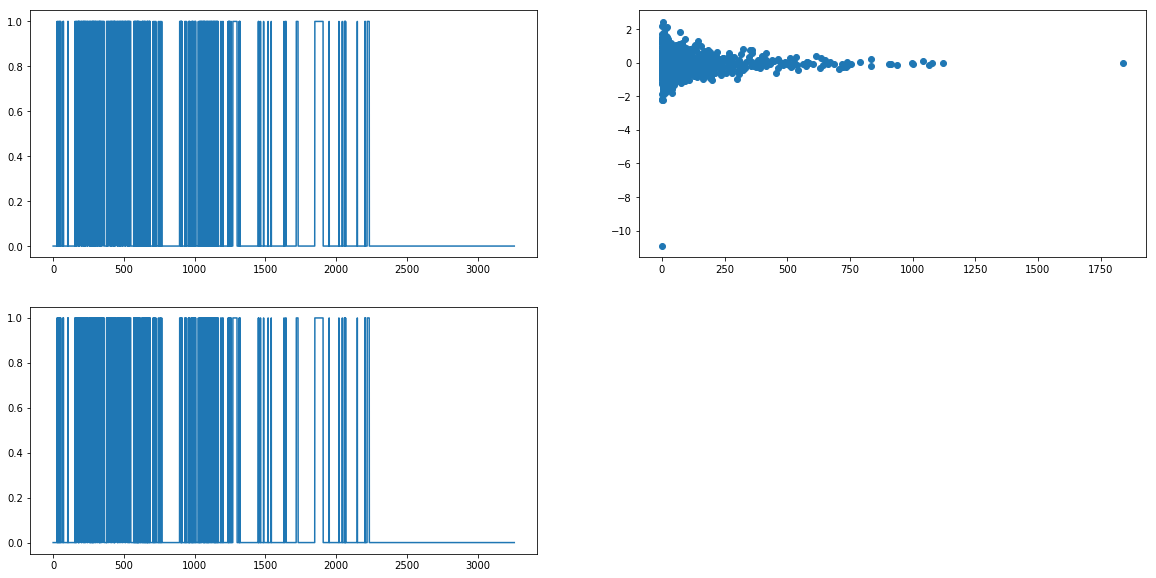

In [115]:
fig = plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(labels)

plt.subplot(222)
plt.scatter(x=e,y=GFT(labels))

plt.subplot(223)
plt.plot(iGFT(GFT(labels)))

In [116]:
def heat_kernel(e, t):
    return np.diag(np.exp(-t*e))

def inverse_kernel(e, t):
    return np.diag(1/(1+t*e))

def rectangle_kernel(e, l_min, l_max):
    return np.diag((e>=l_min)&(e<=l_max).astype(int))

def graph_filter(x, kernel, **kwargs):
    return (GFT((kernel(**kwargs))) @ U).dot(x)# Your code here.
    #return U.T @ kernel(**kwargs) @ U

In [162]:
#noise_variance = np.var(test_label)/SNR# Your code here.
SNR = 5

noise_variance = np.var(labels)/SNR# Your code here.
noisy_measurements = labels.ravel() + np.sqrt(noise_variance) * np.random.randn(n_nodes)
noisy_measurements = noisy_measurements.reshape(noisy_measurements.shape[0],1)

f_in = noisy_measurements

#f_out = graph_filter(x=f_in, kernel=rectangle_kernel, e=e,l_min=-0.001,l_max=10)
#f_out = graph_filter(x=f_in, kernel=heat_kernel, e=e,t = 0.07)
f_out = graph_filter(x=f_in, kernel=inverse_kernel, e=e,t = 0.07)
#f_out = h.dot(f_in)


Text(0.5,1,'Recovered signal')

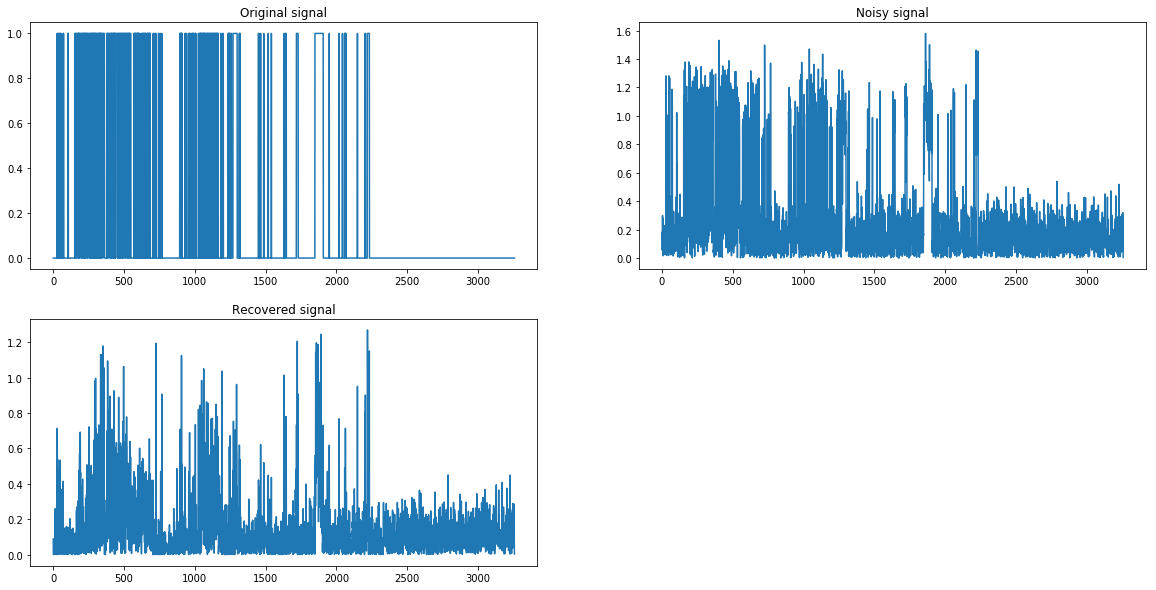

In [161]:
fig = plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(labels)
plt.title('Original signal')

plt.subplot(222)
plt.plot(abs(f_in))
plt.title('Noisy signal')

plt.subplot(223)
plt.plot(abs(f_out))
plt.title('Recovered signal')

### Question 3

Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

### Question 4

Plot your feature/label vector as a signal on your graph

Text(0.5,1,'Plot for the top-5 busiest airports in our data')

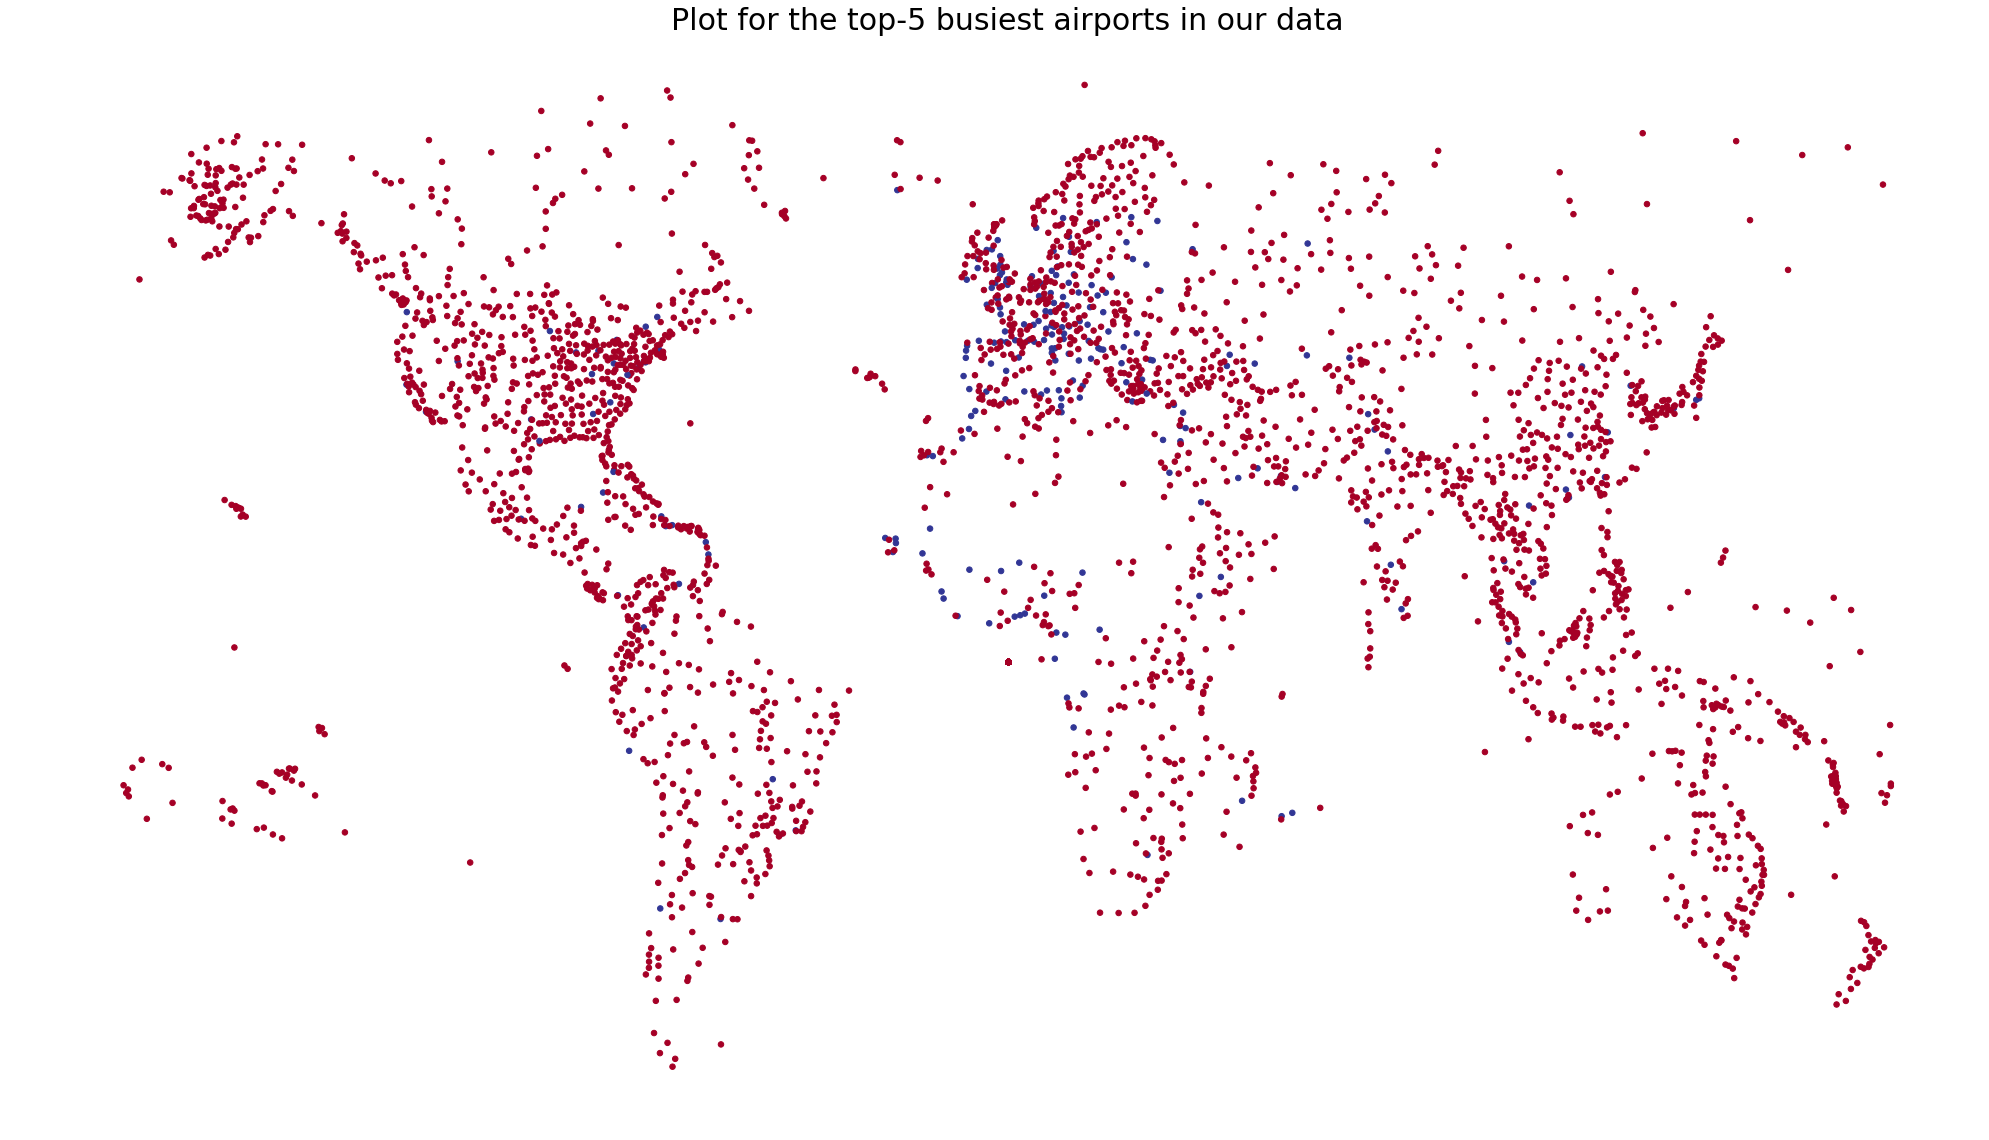

In [21]:
plt.figure(figsize=(15*1.8,15))

nx.draw(G, pos=pos,node_size=30,width=0,node_color=labels,cmap='RdYlBu')
plt.title('Plot for the top-5 busiest airports in our data',fontsize='30')
# mplleaflet.show()
# mplleaflet.display(fig=ax.figure)
# mplleaflet.show(fig=ax.figure,path='test.html')

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

### Question 7

Plot all three filter kernels in the **spectral domain**. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

Text(0,0.5,'Spectral Value')

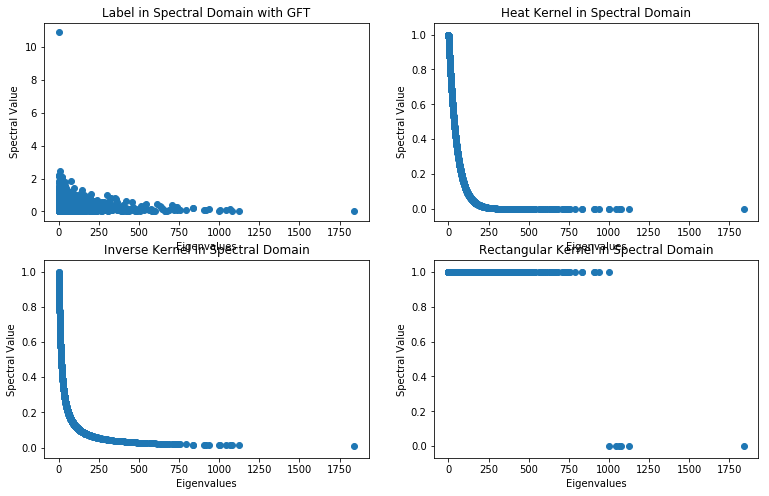

In [157]:
# Your code here.
plt.figure(figsize=(8*1.6,8))

test_label = labels

plt.subplot(221)
plt.scatter(x=e, y=abs(GFT(test_label)).ravel(),cmap='RdBu')
plt.xlabel('Eigenvalues')
plt.ylabel('Spectral Value')
plt.title('Label in Spectral Domain with GFT')

plt.subplot(222)
plt.scatter(x=e,y=np.diag(heat_kernel(e=e,t=0.02)),cmap='RdBu')
plt.title('Heat Kernel in Spectral Domain')
plt.xlabel('Eigenvalues')
plt.ylabel('Spectral Value')

plt.subplot(223)
plt.scatter(x=e,y=np.diag(inverse_kernel(e=e,t=0.07)),cmap='RdBu')
plt.title('Inverse Kernel in Spectral Domain')
plt.xlabel('Eigenvalues')
plt.ylabel('Spectral Value')

plt.subplot(224)
plt.scatter(x=e,y=np.diag(rectangle_kernel(e=e,l_min=-0.001,l_max=1000)),cmap='RdBu')
plt.title('Rectangular Kernel in Spectral Domain')
plt.xlabel('Eigenvalues')
plt.ylabel('Spectral Value')


## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [51]:
SNR = 1.5
test_label = labels.reshape(labels.shape[0],1)
#test_label = U[:,1].reshape(U[:,1].shape[0],1)
test_label[test_label<0]=-1
test_label[test_label>=0]=1

noise_variance = np.var(test_label)/SNR# Your code here.
noisy_measurements = test_label.ravel() + np.sqrt(noise_variance) * np.random.randn(n_nodes)
noisy_measurements = noisy_measurements.reshape(noisy_measurements.shape[0],1)

### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

In [54]:
signal = noisy_measurements
heat_denoise = graph_filter(x=signal, kernel=heat_kernel, e=e,t=0.001)
heat_denoise = heat_denoise/np.max(heat_denoise)
# heat_denoise[heat_denoise>=1] = 1
# heat_denoise[heat_denoise<1] = -1

inverse_denoise = graph_filter(x=signal, kernel=inverse_kernel, e=e,t=0.001)
inverse_denoise = inverse_denoise/np.max(inverse_denoise)
# inverse_denoise[inverse_denoise>=1] = 1
# inverse_denoise[inverse_denoise<1] = -1

rec_denoise = graph_filter(x=signal, kernel=rectangle_kernel, e=e,l_min=-0.001, l_max=500)
rec_denoise = rec_denoise/np.max(rec_denoise)
# rec_denoise[rec_denoise>=1] = 1
# rec_denoise[rec_denoise<1] = -1

In [59]:
np.diag(1/(1+gamma*e))

array([1.])

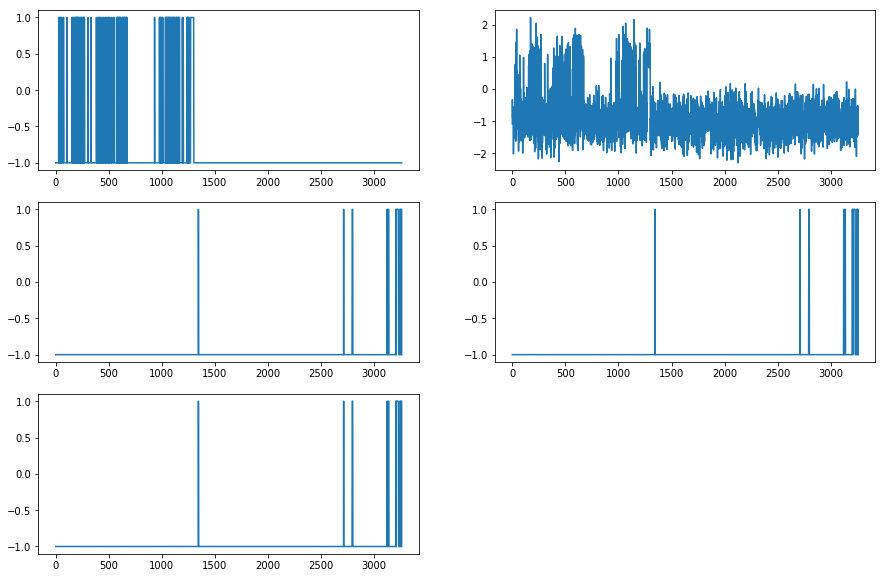

In [55]:
plt.figure(figsize=(15,10))
plt.subplot(321)
plt.plot(test_label)

plt.subplot(322)
plt.plot(signal)

plt.subplot(323)
plt.plot(heat_denoise)

plt.subplot(324)
plt.plot(inverse_denoise)

plt.subplot(325)
plt.plot(rec_denoise)

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

In [ ]:
plt.figure(figsize=(12,12))

plt.subplot(321)
nx.draw(G, pos=pos,node_size=10, node_color=test_label.ravel(),width=0,cmap='RdYlBu')
plt.title('Orignal signal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(322)
noisy_bin = noisy_measurements
noisy_bin[noisy_bin>=0] = 1
noisy_bin[noisy_bin<0] = -1
nx.draw(G, pos=pos,node_size=10, node_color=noisy_bin.ravel(),width=0,cmap='RdYlBu')
plt.title('Noisy measurement')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


plt.subplot(323)
nx.draw(G, pos=pos,node_size=10, node_color=heat_denoise.ravel(),width=0,cmap='RdYlBu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Denoised by Heat Kernel')

plt.subplot(324)
nx.draw(G, pos=pos,node_size=10, node_color=inverse_denoise.ravel(),width=0,cmap='RdYlBu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Denoised by Inverse Kernel')

plt.subplot(325)
nx.draw(G, pos=pos,node_size=10, node_color=rec_denoise.ravel(),width=0,cmap='RdYlBu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Denoised by Rectangular Kernel')

In [35]:
# Your code here.
def rel_err(label,z):
    return np.linalg.norm(label-z)/np.linalg.norm(label)

In [47]:
print(rel_err(test_label,noisy_measurements))

0.20408697710677837


In [48]:
print(rel_err(test_label,inverse_denoise))

0.00023077651105083848


In [49]:
print(rel_err(test_label,rec_denoise))

0.00023335896523345127


In [50]:
print(rel_err(test_label,heat_denoise))

0.00023075640831669885


Finally, overlay on the same plot the GFT of all five signals above.

In [ ]:
# Your code here.

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

**Your answer here.**